In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=6,
    lora_alpha=24,
    lora_dropout=0.05,
    bias = 'none',
    target_modules = ['query','value'],
    task_type="SEQ_CLS",
)

We used a LoRA configuration with a low-rank dimension of `r=6`, which offers sufficient capacity to learn task-specific patterns while keeping the trainable parameter count low. The scaling factor `lora_alpha=24` was selected as a multiple of r to maintain stable training. A dropout rate of `0.05` was applied to regularize the LoRA layers and reduce overfitting.

To further minimize parameters, we set `bias='none'`, avoiding updates to bias terms. We targeted only the query and value projections in the attention layers, which are the most influential components for learning in transformer architectures.



In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


Total number of trainable parameters : **814,852**

---



## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup Training args
output_dir = "/content/drive/MyDrive/DL_Project_2/results/Final_Results"

training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

The model was trained for 6 epochs with a batch size of `16` for training and `64` for evaluation. A learning rate of `5e-5` was used in conjunction with the AdamW optimizer adamw_torch, which is well-suited for training transformer models.

To improve generalization and training stability, we used a cosine learning rate scheduler `lr_scheduler_type="cosine"` with a warmup ratio of `10%`. Weight decay `weight_decay=0.01` was applied to reduce overfitting. The training was performed with mixed-precision `fp16=True` to speed up computation and reduce memory usage when running on GPUs.

Evaluation and model checkpointing were performed at the end of each epoch `eval_strategy='epoch'`, `save_strategy='epoch'`. We enabled load_best_model_at_end=True so that the final model corresponds to the checkpoint with the highest validation accuracy. We also set `metric_for_best_model='accuracy'` and `greater_is_better=True` to ensure the model is selected based on its best accuracy score. Logging occurred every 100 steps to monitor training progress.

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.244600,0.265311,0.918750,0.919981,0.921045,0.919514
2,0.200200,0.224881,0.928125,0.933261,0.927033,0.929490
3,0.221800,0.218428,0.932813,0.934615,0.933806,0.934151
4,0.219600,0.213195,0.928125,0.932169,0.927532,0.929402
5,0.190900,0.211476,0.931250,0.936207,0.930340,0.932655
6,0.190500,0.214872,0.931250,0.935690,0.930615,0.932674


**Best Model Metrics (Epoch 3)**

* Training Loss: 0.2218

* Validation Loss: 0.2184

* Accuracy: 93.28%

* Precision: 93.46%

* Recall: 93.38%

* F1 Score: 93.42%





## Evaluate Finetuned Model


### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 38.45it/s]

Evaluation Metric: {'accuracy': 0.9328125}


### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/content/drive/MyDrive/DL_Project_2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output_final.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:22<00:00, 43.93it/s]

Inference complete. Predictions saved to inference_output.csv


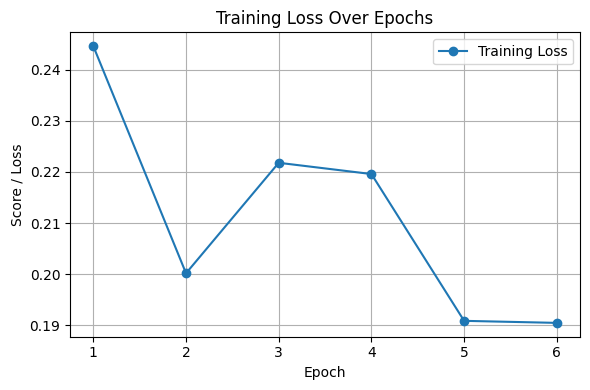

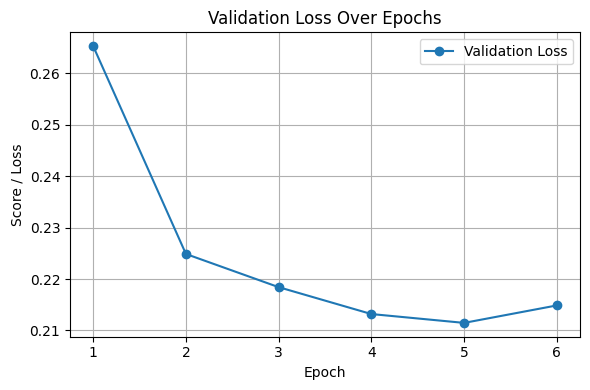

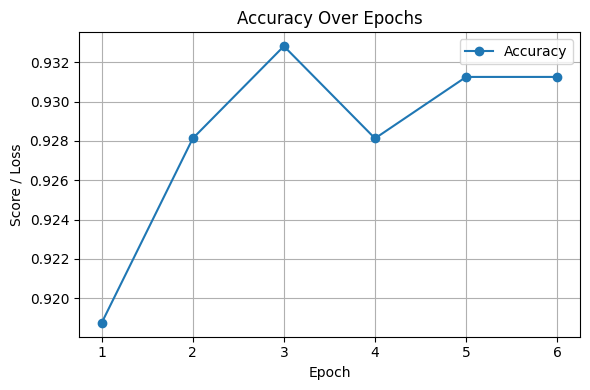

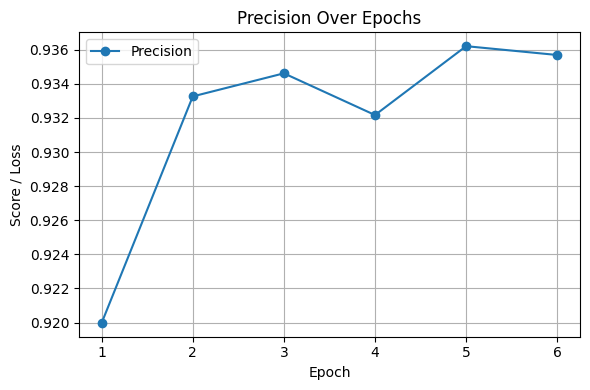

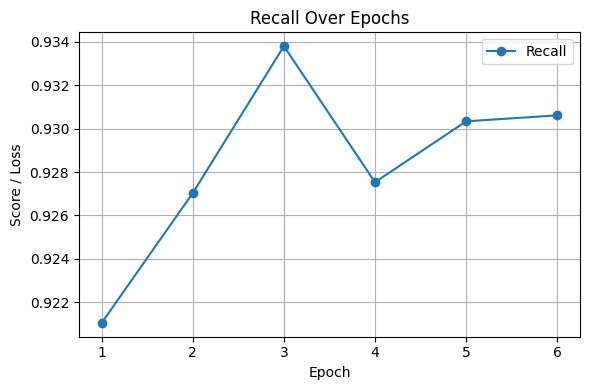

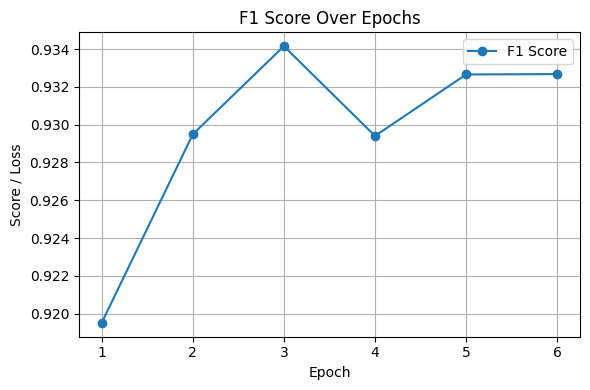

In [1]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6]
training_loss = [0.244600, 0.200200, 0.221800, 0.219600, 0.190900, 0.190500]
validation_loss = [0.265311, 0.224881, 0.218428, 0.213195, 0.211476, 0.214872]
accuracy = [0.918750, 0.928125, 0.932813, 0.928125, 0.931250, 0.931250]
precision = [0.919981, 0.933261, 0.934615, 0.932169, 0.936207, 0.935690]
recall = [0.921045, 0.927033, 0.933806, 0.927532, 0.930340, 0.930615]
f1_score = [0.919514, 0.929490, 0.934151, 0.929402, 0.932655, 0.932674]

metrics = {
    "Training Loss": training_loss,
    "Validation Loss": validation_loss,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
}

for metric_name, values in metrics.items():
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, values, marker='o', linestyle='-', color='tab:blue', label=metric_name)
    plt.title(f"{metric_name} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Score / Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()